## Installation of SMAC and its Dependencies

In [1]:
!apt-get install swig -y
!pip install Cython
!pip install pyrfr==0.8.0 --no-cache --user
# hack to find pyrfr
import sys
sys.path.insert(0,"./.local/lib/python3.6/site-packages")

!pip install git+https://github.com/automl/SMAC3.git@development

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 0 not upgraded.
Need to get 1,080 kB of archives.
After this operation, 5,657 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu artful/universe amd64 swig3.0 amd64 3.0.10-1.2 [1,074 kB]
Get:2 http://archive.ubuntu.com/ubuntu artful/universe amd64 swig amd64 3.0.10-1.2 [6,384 B]
Fetched 1,080 kB in 1s (789 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.10-1.2_amd64.deb ...
Unpacking swig3.0 (3.0.10-1.2) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_3.0.10-1.2_amd64.deb ...
Un

    100% |████████████████████████████████| 2.2MB 15.2MB/s 
    100% |████████████████████████████████| 184kB 24.5MB/s 
    100% |████████████████████████████████| 163kB 25.5MB/s 
    100% |████████████████████████████████| 552kB 20.4MB/s 
    100% |████████████████████████████████| 6.8MB 4.9MB/s 
    100% |████████████████████████████████| 71kB 22.4MB/s 
  Running setup.py bdist_wheel for smac ... - \ | done
  Stored in directory: /tmp/pip-ephem-wheel-cache-90d0fye4/wheels/f4/8d/4f/2ba4cb80693f139ea06c2e8541e012a93738fb56bc1e43a202
  Running setup.py bdist_wheel for pynisher ... - done
  Stored in directory: /content/.cache/pip/wheels/81/35/cb/37fe9c279ac6e56fc8805e146a431c27550dce1ad868ffa04e
  Running setup.py bdist_wheel for ConfigSpace ... - \ | / - \

 | / - \ | / - \ | done
  Stored in directory: /content/.cache/pip/wheels/04/bb/ce/b64b66d9b04eb27445cc5445f69eb35dcd2b5884122be62f13
Successfully built smac pynisher ConfigSpace


## Camel Function

In [0]:
import math
import numpy as np

def camel_func(x):
    # x is vector contains 2 values.
    x1 = x[0]
    x2 = x[1]
    first = (4.0 - 2.1 * x1**2 + (x1**4) / 3.0)
    second = (-4 + 4.0 * x2 ** 2)
    return first * x1 ** 2 + x1 * x2 + second * x2 ** 2

##Loss Function

In [0]:
def loss(x):
  fx = camel_func(x)
  # The minimum value of the function.
  fx_star = -1.0316
  return np.log(fx - fx_star)

## Plot Function

Text(0.5,0,'y')

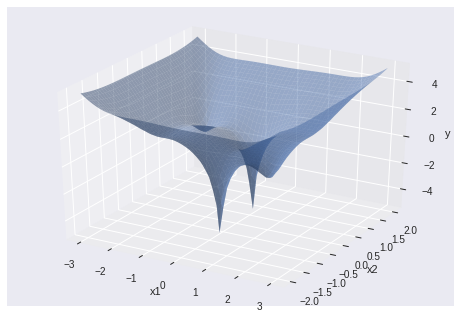

In [4]:
x1_points = np.linspace(start=-3,stop=3,num=50)
x2_points = np.linspace(start=-2,stop=2,num=50)

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x1_points, x2_points = np.meshgrid(x1_points, x2_points)
y_points = np.array([loss([x1 ,x2]) for x1, x2 in zip(x1_points, x2_points)])
ax.plot_surface(x1_points, x2_points, y_points, alpha = .5)

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')



## Optimize with SMAC

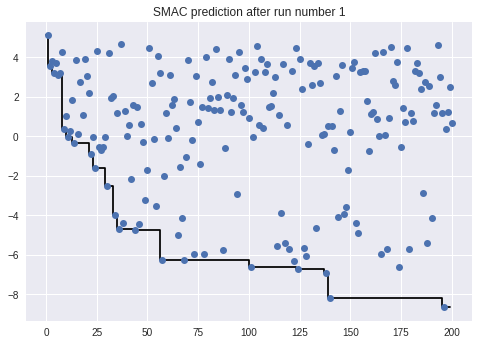

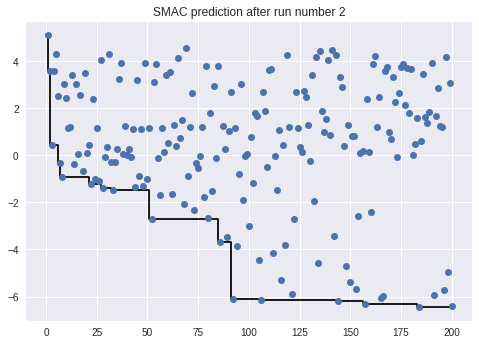

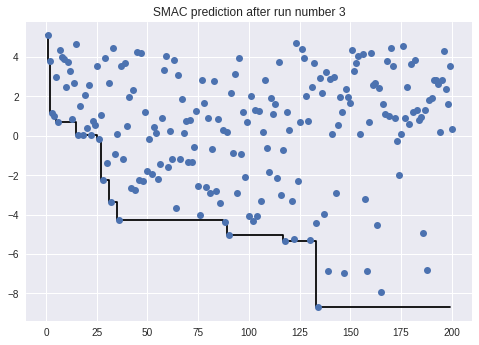

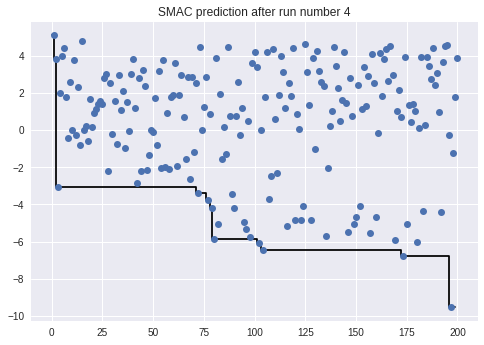

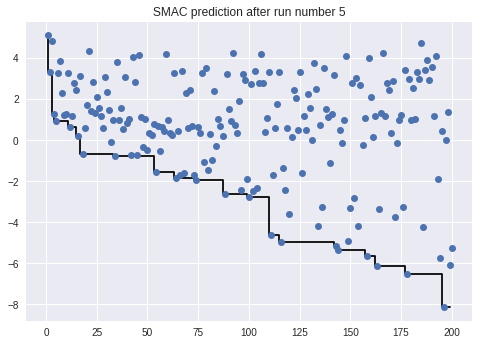

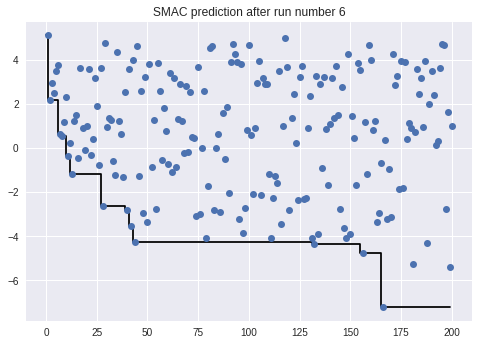

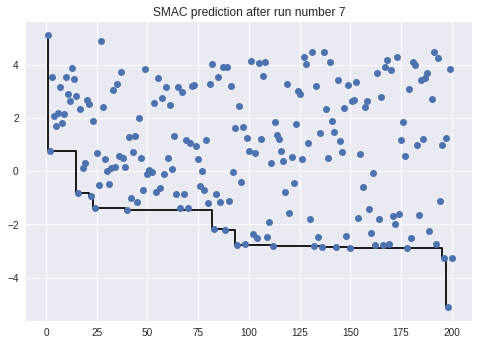

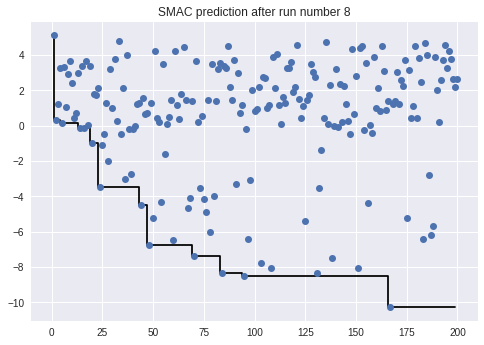

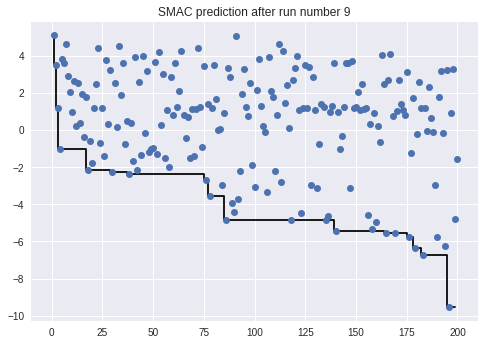

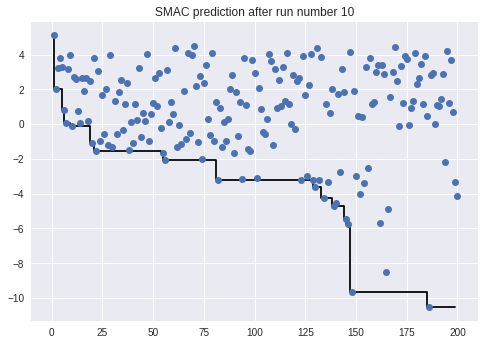

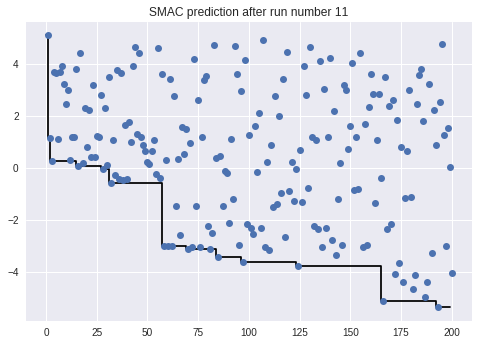

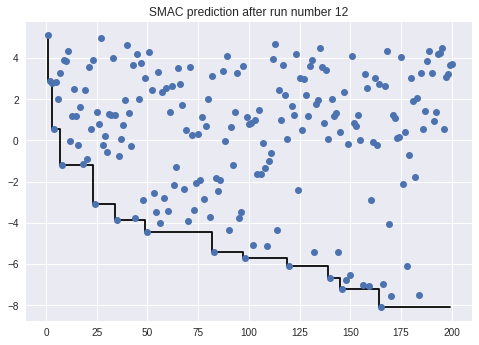

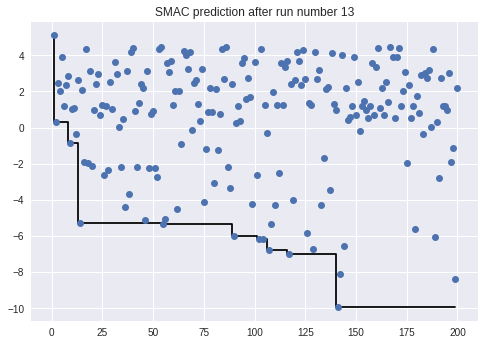

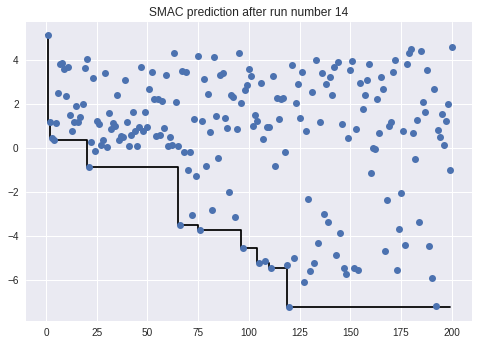

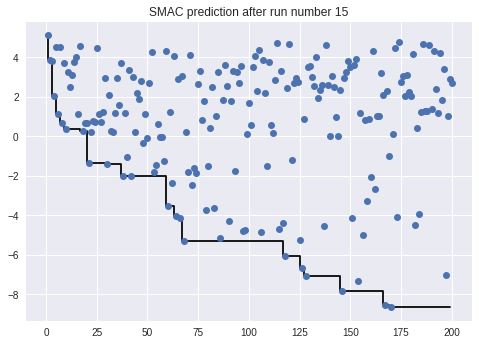

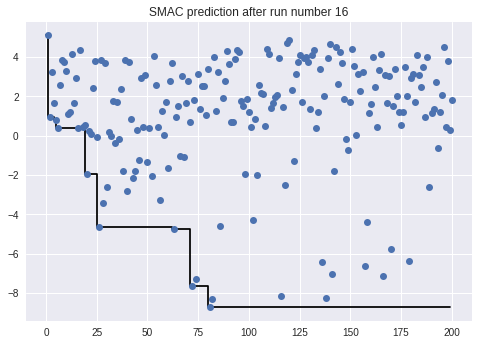

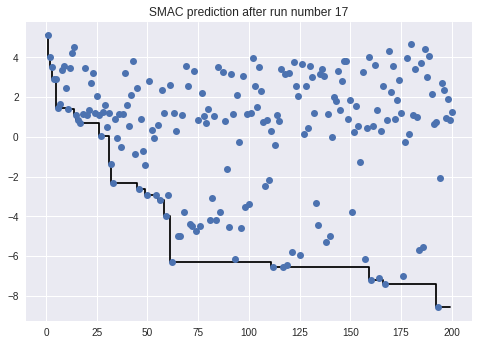

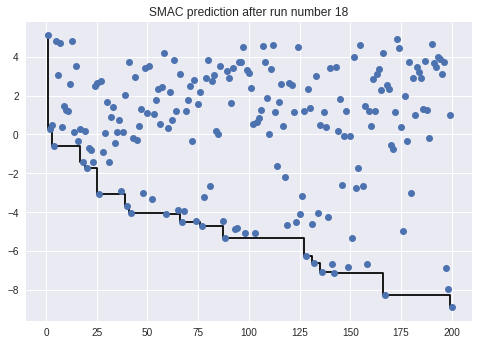

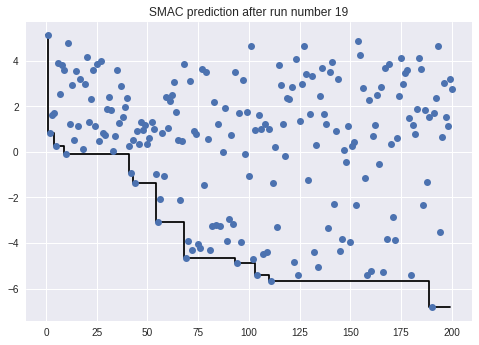

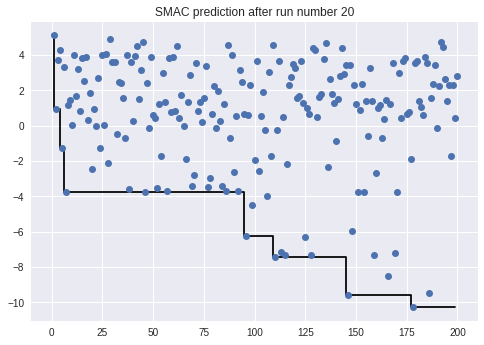

In [53]:
import numpy as np
from smac.facade.func_facade import fmin_smac

MAX_FUN = 200
full_data = [] # 2d Matrix for function evalution and 20 runs
for index in range(20):
  # Random Seed to make plot different.
  seed = np.random.randint(1111,2222)
  x, cost, smac = fmin_smac(func=loss,
                         x0=[-3, -2], # default values
                         bounds=[(-3, 3), (-2, 2)], # bounds of each x
                         maxfun=MAX_FUN, # maximal number of function evaluations 
                         rng=np.random.RandomState(seed) # random seed
                         )
  runhistory = smac.get_runhistory()
  y_smac = []
  # Assure that the step function is strictly decreasing.
  for entry in runhistory.data: 
    config_id = entry.config_id
    config = runhistory.ids_config[config_id] 
    y_ = runhistory.get_cost(config) 
    y_smac.append(y_)
  
  full_data.append(y_smac)
  y_smac = np.array(y_smac)
  loss_value = []
  x_loss = []
  min_loss = 1e9
  x_loss.extend(range(1, MAX_FUN + 1))
  # Assure that the step function is strictly decreasing.
  for idx in range(MAX_FUN):
    min_loss = min(min_loss, y_smac[idx])
    loss_value.append(min_loss)
  # Plot the step function and the function evaluations.
  fig1 = plt.figure()
  ax1 = fig1.add_subplot(111)
  ax1.step(loss_value, 'k', where="post")
  ax1.plot(x_loss, y_smac, 'o')
  plt.title("SMAC prediction after run number %i"% (index + 1))
  plt.show()


## How has SMAC performed over time?

Text(0.5,1,'SMAC Performance')

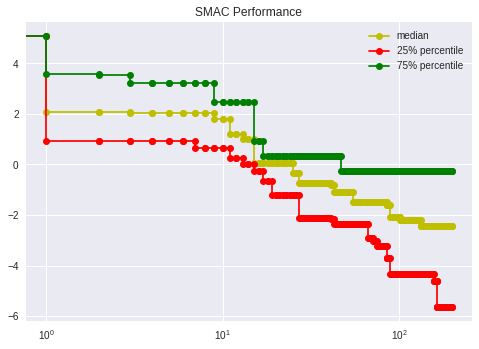

In [66]:
full_data = np.array(full_data)
# Transpose the matrix to get the 20 runs of each evaluation.
full_data = np.transpose(full_data)
# Median, 25% and 75 percentiles.
med, quart, triquart = [], [], []

for index in range(MAX_FUN):
  single_run = full_data[index]
  single_run = np.sort(single_run)
  med.append(np.percentile(single_run, 50))
  quart.append(np.percentile(single_run, 25))
  triquart.append(np.percentile(single_run, 75))
  
min_med, min_quart, min_tri = 1e9, 1e9, 1e9
# Assure that each step function is decreasing.
for idx in range(MAX_FUN):
  min_med = med[idx] = min(med[idx], min_med)
  min_quart = quart[idx] = min(quart[idx], min_quart)
  min_tri = triquart[idx] = min(triquart[idx], min_tri)
# Plotting the 3 function side by side.
fig = plt.figure()
ax = fig.add_subplot(111)
ax.step(med, 'yo', where='post', label='median')
ax.step(quart, 'ro', where='post', label='25% percentile')
ax.step(triquart, 'go', where='post', label = '75% percentile')
ax.legend(loc = 'upper right')
ax.set_xscale('log')
plt.title('SMAC Performance')

## Random Search : ROAR

In [0]:
from smac.facade.roar_facade import ROAR
from smac.scenario.scenario import Scenario
from smac.configspace import ConfigurationSpace
from ConfigSpace.hyperparameters import UniformFloatHyperparameter



cs = ConfigurationSpace()

# Declaring Variables in configuration space. 
x1_points = UniformFloatHyperparameter("x1", -3, 3, default_value=-3)
x2_points = UniformFloatHyperparameter("x2", -2, 2, default_value=-2)

cs.add_hyperparameters([x1_points, x2_points])
scenario = Scenario({"run_obj": "quality",   # we optimize quality (alternative runtime)
                      "wallclock_limit": 12, # time for running SMAC
                     "deterministic": "true",
                     "cs": cs,
                     "memory_limit": 3072,   # adapt this to reasonable value for your hardware
                     "output_dir": ""        # deactivate output
                    })
def cfg(cfg, seed):
    return  loss([cfg["x1"], cfg["x2"]])

roar_data = []

# Putting ROAR values in 2d matrix like SMAC.
for index in range(20):
  y_roar = []
  seed = np.random.randint(1111,2222)
  roar = ROAR(scenario=scenario, rng=np.random.RandomState(seed),
              tae_runner=cfg)
  incumbent = roar.optimize()
  history = roar.get_runhistory()
  for entry in history.data: 
    config_id = entry.config_id
    config = history.ids_config[config_id] 
    y_ = history.get_cost(config) 
    y_roar.append(y_)
  
  y_roar = y_roar[:MAX_FUN]
  y_roar = np.array(y_roar)
  roar_data.append(y_roar)


roar_data = np.array(roar_data)
roar_data = np.transpose(roar_data)

## Plot ROAR

Text(0.5,1,'ROAR vs SMAC')

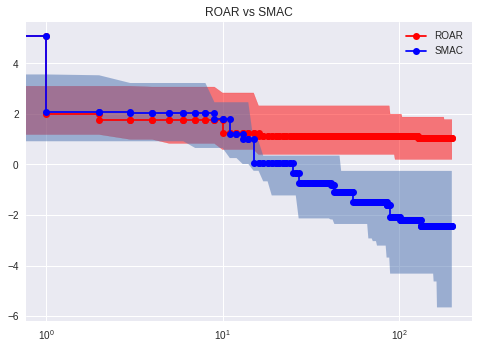

In [98]:

# Calculating ROAR percentiles and Plotting them beside SMAC.
rmed, rquart, rtriquart = [], [], []

for index in range(MAX_FUN):
  single_run = roar_data[index]
  single_run = np.sort(single_run)
  rmed.append(np.percentile(single_run, 50))
  rquart.append(np.percentile(single_run, 25))
  rtriquart.append(np.percentile(single_run, 75))
  
min_rmed, min_rquart, min_rtri = 1e9, 1e9, 1e9
for idx in range(MAX_FUN):
  min_rmed = rmed[idx] = min(rmed[idx], min_rmed)
  min_rquart = rquart[idx] = min(rquart[idx], min_rquart)
  min_rtri = rtriquart[idx] = min(rtriquart[idx], min_rtri)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.step(rmed, 'ro', where='post', label='ROAR')
ax.fill_between (range(MAX_FUN), rquart, rtriquart, alpha=0.5, color='r')
ax.step(med, 'bo', where='post', label='SMAC')
ax.fill_between (range(MAX_FUN), quart, triquart, alpha=0.5)
ax.legend(loc = 'upper right')
ax.set_xscale('log')
plt.title('ROAR vs SMAC')
  
